<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background- padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Sales Forecasting using Teradata UAF (Unbounded Array Framework)
  <br>
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>

<p style='font-size:20px;font-family:Arial'><b>Introduction</b></p>

<p style = 'font-size:16px;font-family:Arial'>Predicting future sales is crucial for any company as it helps in making informed business decisions. However, these sales are usually impacted by a plethora of reasons including seasonality, sales, macro-economic conditions throughout the year which can result in sales being significantly higher or lower than average. This can negatively impact future revenue if sales are not accurately predicted.</p>

<p style='font-size:18px;font-family:Arial'><b>Solution</b></p>

<p style = 'font-size:16px;font-family:Arial'>We forecast the amount of future sales by developing a time-series modelling pipeline on sales data. The demo shows the power of Vantage through its In-DB analytics time-series capabilities which provides a comprehensive suite of functions most commonly used by Data Scientists across the industry in forecasting pipelines including but not limited to the following standard activities;</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Data preparation: Resampling, convert irregular to regular</li>
    <li>Data exploration: Detect stationarity and periodicity</li>
    <li>Eliminate Non-stationarity: Seasonal normalizing</li>
    <li>Formulate candidate models: ARIMA</li>
    <li>Goodness of Fit: Parameter estimates, hypothesis statistical tests</li>
    <li>Model Validation: ARIMA Validate</li>
    <li>Model Forecasting: Unnormalize, and forecast on test data</li>
</ul>


<p style='font-size:18px;font-family:Arial'><b>Sales Forecasting Demo Data</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Features</b>: Other exogenous features related to store and environment for time-series analysis</p>
<p style = 'font-size:16px;font-family:Arial'><b>Train</b>: Weekly sales input data for time-series analysis</p>
<p style = 'font-size:16px;font-family:Arial'><b>Test</b>: Weekly sales test data for time-series model testing</p>
<p style = 'font-size:16px;font-family:Arial'><b>Store</b>: Anonymized information about the 45 stores, indicating the type and size of the store</p>

      
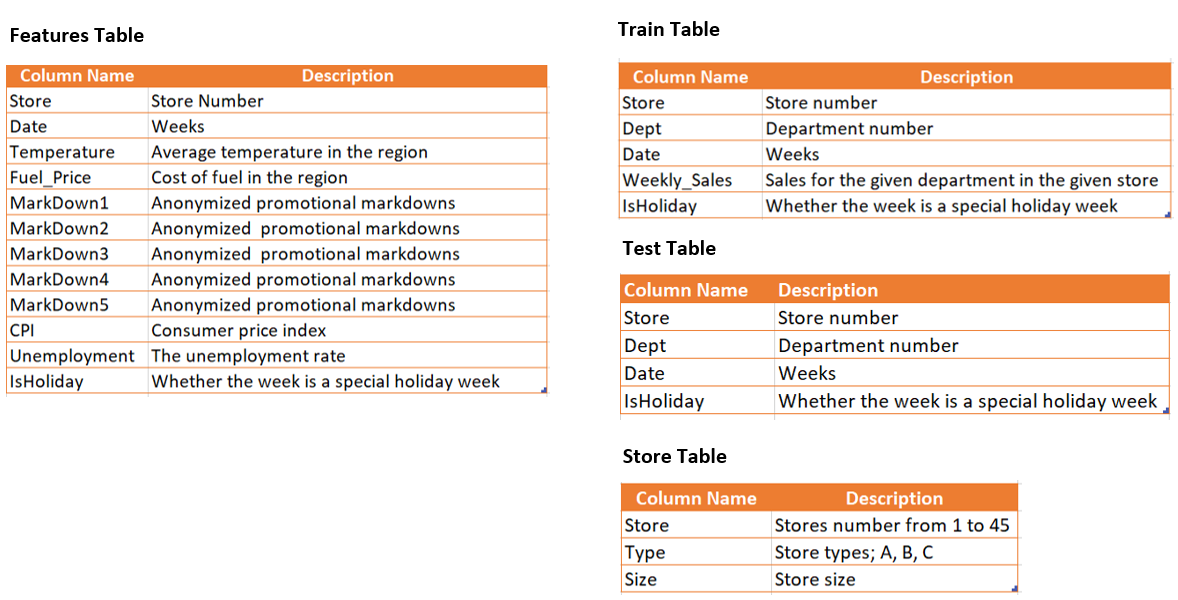
    
<p style='font-size:18px;font-family:Arial'><b>Unbounded Array Framework (UAF) Specifications</b></p>

<p style = 'font-size:16px;font-family:Arial'>Unbounded Array Framework (UAF) is the Teradata framework for building end-to-end time series forecasting pipelines. It takes the following as inputs.</p>

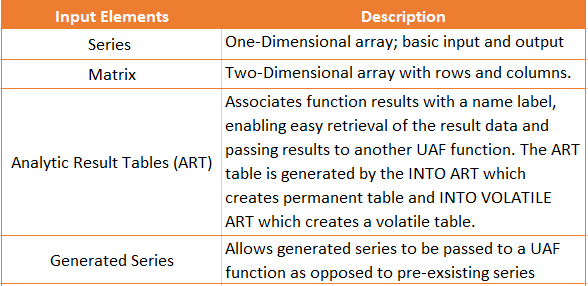

<p style = 'font-size:16px;font-family:Arial'>For further information, please <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Unbounded-Array-Framework-Specifications'>refer here</a></p>

<hr style="height:2px;border:none;">
<p style = 'font-size:18px;font-family:Arial'><b>Downloading and installing additional software needed</b>

<p style = 'font-size:16px;font-family:Arial'>Here, we import the required libraries, set environment variables and environment paths (if required).</p>

In [ ]:
# Standard Python libraries
import csv
import getpass
import io

# Third-party libraries
import pandas as pd
import sqlalchemy
from sqlalchemy import event
from collections import OrderedDict
from PIL import Image

# Teradata related imports
import teradataml as tdml
from teradataml import *
from teradatasqlalchemy.types import *
from teradataml import to_numeric

# Modify the following to match the specific client environment settings
display.max_rows = 5
configure.val_install_location = 'val'

<hr style="height:2px;border:none;">
<b style = 'font-size:20px;font-family:Arial'>1. Initiate a connection to Vantage</b>
<p style = 'font-size:16px;font-family:Arial'>You will be prompted to provide the password. Enter your password, press the Enter key, and then use the down arrow to go to the next cell.</p>

In [ ]:
%run -i ../startup.ipynb
eng = create_context(host = 'host.docker.internal', username='demo_user', password = password)
print(eng)

In [ ]:
%%capture
execute_sql('''SET query_band='DEMO=Sales_Forecasting_UAF_PY_SQL.ipynb;' UPDATE FOR SESSION;''')

<p style = 'font-size:16px;font-family:Arial'>Begin running steps with Shift + Enter keys. </p>

<p style = 'font-size:20px;font-family:Arial'><b>Getting Data for This Demo</b></p>
<p style = 'font-size:16px;font-family:Arial'>We have provided data for this demo on cloud storage. You can either run the demo using foreign tables to access the data without any storage on your environment or download the data to local storage, which may yield faster execution. Still, there could be considerations of available storage. Two statements are in the following cell, and one is commented out. You may switch which mode you choose by changing the comment string.</p>

In [ ]:
# %run -i ../run_procedure.py "call get_data('DEMO_SalesForecastingUAF_cloud');"        # Takes 1 minute
%run -i ../run_procedure.py "call get_data('DEMO_SalesForecastingUAF_local');"        # Takes 2 minutes

<p style = 'font-size:16px;font-family:Arial'>Next is an optional step – if you want to see the status of databases/tables created and space used.</p>

In [ ]:
%run -i ../run_procedure.py "call space_report();"        # Takes 10 seconds

<hr style="height:2px;border:none;">
<b style = 'font-size:20px;font-family:Arial'>2. Loading and Preparing Data</b>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Create dataframes for Sales, Features, and Stores tables in the Vantage Advanced SQL Engine</li>
</ul>

In [ ]:
sales_data = DataFrame(in_schema('DEMO_SalesForecastingUAF', 'Weekly_Sales'))
feature_data = DataFrame(in_schema('DEMO_SalesForecastingUAF', 'Features')).drop(['IsHoliday'], axis=1)
store_data = DataFrame(in_schema('DEMO_SalesForecastingUAF', 'Stores'))

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Join datasets to create the ADS using tdml for basic dataframe manipulations</li>
</ul>

In [ ]:
# Join store_data with sales_data
sales_data = sales_data.join(store_data, on='Store', how='left', lprefix='t1', rprefix='t2').drop(['t2_Store'], axis=1)
sales_data = sales_data.assign(Store=sales_data['t1_Store'])
sales_data = sales_data.drop(['t1_Store'], axis=1)

# Join feature_data with sales_data
sales_data = sales_data.join(feature_data, on=['Store', 'Date'], how='left', lprefix='t1', rprefix='t3').drop(['t3_Store'], axis=1).drop(['t3_Date'], axis=1)
sales_data = sales_data.assign(Store=sales_data['t1_Store'])
sales_data = sales_data.assign(Date=sales_data['t1_Date'])
sales_data = sales_data.drop(['t1_Store'], axis=1)
sales_data = sales_data.drop(['t1_Date'], axis=1)

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Creating time series identifier for partitioning.</li>
    <li>The series identifier was created by joining the department and store ID which provides a unique ID for every time series.</li>
</ul>

In [ ]:
# Assign a new column 'idcols' based on string concatenation
sales_data = sales_data.assign(idcols=sales_data.Dept.str.strip() + '-' + sales_data.Store.str.strip())
sales_data = sales_data.assign(idcols=sales_data.idcols.cast(type_=VARCHAR(10)))

# Check the shape of the DataFrame
sales_data.shape

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Create a table in Vantage based on a TeradataML DataFrame.</li>
</ul>

In [ ]:
copy_to_sql(df = sales_data, table_name = "az_sf_joined", if_exists = "replace")

<p style = 'font-size:16px;font-family:Arial'><b><i>*Please scroll down to the end of the notebook for detailed column descriptions of the dataset.</i></b></p>

In [ ]:
az_sf_joined = DataFrame('az_sf_joined')
az_sf_joined[az_sf_joined["idcols"] == "40-41"]

<hr style="height:2px;border:none;">
<b style = 'font-size:20px;font-family:Arial'>3. Data Cleaning</b>

<p style='font-size:18px;font-family:Arial'><b>TD_OutlierFilterFit</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>

<p style = 'font-size:16px;font-family:Arial'>TD_OutlierFilterFit function calculates the lower_percentile, upper_percentile, count of rows, and median for the specified input table columns. The calculated values for each column help the TD_OutlierFilterTransform function detect outliers in the input table.</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>

<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Data-Cleaning-Functions/Handling-Outliers/TD_OutlierFilterFit/TD_OutlierFilterFit-Syntax-Elements'>refer here</a></p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>

<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Data-Cleaning-Functions/Handling-Outliers/TD_OutlierFilterFit/TD_OutlierFilterFit-Output'>refer here</a></p>


<ul style = 'font-size:16px;font-family:Arial'>
    <li>Drop Table if exists</li>
    <li>Applying the TD_OutlierFilterFit function and building the table for the results</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE outlier_fit AS (
    SELECT * FROM TD_OutlierFilterFit (
        ON az_sf_joined AS InputTable
        USING
            TargetColumns ('Weekly_Sales')
            LowerPercentile (0.05)
            UpperPercentile (0.95)
            OutlierMethod ('percentile')
            ReplacementValue ('delete')
            PercentileMethod ('PercentileCont')
    ) AS dt
) WITH DATA;
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('outlier_fit')
    execute_sql(query)

DataFrame('outlier_fit')

<p style = 'font-size:16px;font-family:Arial'>This output is an intermediate table and will be used as an input in the next step i.e. TD_OutlierFilterTransform.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_OutlierFilterTransform</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>

<p style = 'font-size:16px;font-family:Arial'>Filters outliers from the input table. The metrics for determining outliers come from TD_OutlierFilterFit output. The function uses statistical values from the <b>TD_OutlierFilterFit</b> function and runs it against each column. This function then identifies the odd values which are way above the normal values.</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>

<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Data-Cleaning-Functions/Handling-Outliers/TD_OutlierFilterTransform/TD_OutlierFilterTransform-Input'>refer here</a></p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>

<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Data-Cleaning-Functions/Handling-Outliers/TD_OutlierFilterTransform/TD_OutlierFilterTransform-Output'>refer here</a></p>


<ul style = 'font-size:16px;font-family:Arial'>
    <li>Creating an actual table TD_OutlierFilterTransform which is described in the above step.</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE OutlierFilterTransform AS (
    SELECT * FROM TD_OutlierFilterTransform (
        ON az_sf_joined AS InputTable PARTITION BY ANY
        ON outlier_fit AS FitTable DIMENSION
    ) AS dt
) 
WITH DATA;
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('OutlierFilterTransform')
    execute_sql(query)

DataFrame('OutlierFilterTransform')

<p style = 'font-size:16px;font-family:Arial'>The outliers have been removed from the data for each of the feature.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Checking if any null values are present after filtering out the outliers.</li>
</ul>

In [ ]:
query = '''
    SELECT COUNT(*) as "Count"
    FROM OutlierFilterTransform
    WHERE Weekly_Sales IS NULL;
'''

DataFrame.from_query(query)

<p style = 'font-size:16px;font-family:Arial'>This shows that there are no null values after filtering out the outliers.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Printing the number of weekly sales after the outliers are dropped.</li>
</ul>

In [ ]:
query = '''
    SELECT COUNT(*) as Weekly_Sales
    FROM OutlierFilterTransform
'''

DataFrame.from_query(query)

<p style = 'font-size:16px;font-family:Arial'>The above output shows count of weekly sales in the transformed dataset.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_Resample</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>

<p style = 'font-size:16px;font-family:Arial'>Once the outliers are removed, the time series is converted to an irregular series.</p>
<p style = 'font-size:16px;font-family:Arial'>TD_Resample Transforms converts irregular time series into a regular time series and performs linear interpolation.</p>
<p style = 'font-size:16px;font-family:Arial'>It can also be used to alter the sampling interval for a time series.</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>

<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Data-Preparation-Functions/TD_RESAMPLE/TD_RESAMPLE-Syntax-Elements'>refer here</a></p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>

<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Data-Preparation-Functions/TD_RESAMPLE/TD_RESAMPLE-Output'>refer here</a></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Randomly selecting store and department ID to see if there are any missing timestamps.</li>
</ul>

In [ ]:
query = '''
    SELECT *
    FROM OutlierFilterTransform
    WHERE dept = 59 AND store = 43
'''

DataFrame.from_query(query).sort('times')

<p style = 'font-size:16px;font-family:Arial'>Dept. No. 59 and Store No. 43 are showed here as a sample.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Randomly selecting a different store and department ID to see if there are any missing timestamps.</li>
</ul>

In [ ]:
query = '''
    SELECT *
    FROM OutlierFilterTransform
    WHERE dept = 59 AND store = 5
'''

DataFrame.from_query(query).sort('times')

<p style = 'font-size:16px;font-family:Arial'>Dept. No. 59 and Store No. 5 are shown here as a sample.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Subtracting the two time series of specific department and store ID's to check the missing time stamps between these two, because we are assuming that if these department and store ID's have missing time stamps then the rest of the ID's will follow the same pattern.</li>
</ul>

In [ ]:
query = '''
    SELECT times
    FROM OutlierFilterTransform
    WHERE dept = 59 AND store = 43

    MINUS

    SELECT times
    FROM OutlierFilterTransform
    WHERE dept = 59 AND store = 5;
'''

DataFrame.from_query(query)

<p style = 'font-size:16px;font-family:Arial'>The above output shows that there are missing timestamps between Store No. 43 and Store No. 5. We can say that there can be missing time stamps in rest of the store as well.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Finding the minimum date, so that we can re-sample the dates from this date onwards.</li>
    <li>Printing the minimum date</li>
</ul>

In [ ]:
DataFrame.from_query('SELECT MINIMUM(times) as minimum_time FROM OutlierFilterTransform;')

<p style = 'font-size:16px;font-family:Arial'>The minimum date is extracted here so as to use it in the next step.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Calling the resample function to convert irregular time series into a regular time series</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(ts_sf_resampled_ads_tw)

TD_RESAMPLE(
    SERIES_SPEC( 
         TABLE_NAME(OutlierFilterTransform),
         ROW_AXIS(timecode(times)),
         SERIES_ID(idcols),
         PAYLOAD(FIELDS(Weekly_Sales),CONTENT(REAL))
     ),
     FUNC_PARAMS(
         TIMECODE(
              START_VALUE(TIMESTAMP '2010-02-05 00:00:00'), 
              DURATION(WEEKS(1))
          ),
          INTERPOLATE(LINEAR)
     )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('ts_sf_resampled_ads_tw')
    execute_sql(query)

# Create a DataFrame from a query
DataFrame.from_query('SELECT TOP 10 * FROM ts_sf_resampled_ads_tw').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>Resampling converts irregular time-series into regular time series i.e. makes the interval same throughout the time series.</p>

<hr style="height:1px;border:none;">
<b style = 'font-size:20px;font-family:Arial'>4. Data Exploration</b>

<p style='font-size:18px;font-family:Arial'><b>TD_UnivariateStatistics</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>

<p style = 'font-size:16px;font-family:Arial'>Displays descriptive statistics for each specified numeric input table column.</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>

<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Data-Exploration-Functions/TD_UnivariateStatistics/TD_UnivariateStatistics-Syntax-Elements'>refer here</a></p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>

<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Data-Exploration-Functions/TD_UnivariateStatistics/TD_UnivariateStatistics-Output'>refer here</a></p>

In [ ]:
# Define the SQL query
query = f'''
SELECT * 
FROM TD_UnivariateStatistics (
    ON az_sf_joined AS InputTable
    USING
    TargetColumns ('Size','Weekly_Sales','Fuel_Price','Unemployment','Temperature','CPI')
    Stats( 
              'MEAN',
              'TRIMMED MEAN',
              'MEDIAN',
              'MODE',           
              'SKEWNESS',
              'STANDARD ERROR',
              'STANDARD DEVIATION',
              'KURTOSIS',
              'SUM',
              'RANGE',
              'VARIANCE',
              'INTERQUARTILE RANGE',
              'MINIMUM',
              'MAXIMUM')
    
) As dt;

'''
# Create a DataFrame from a query
DataFrame.from_query(query)

<p style = 'font-size:16px;font-family:Arial'>The output above shows univariate statistics of each of the numeric columns.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_CategoricalSummary</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>

<p style = 'font-size:16px;font-family:Arial'>Displays the distinct values and their counts for each specified input table.</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li><b>Target_column</b>: Column for which to display distinct values and their counts.</li>
</ul>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li><b>ColumnName</b>: Name of target_column.</li>
    <li><b>DistinctValue</b>: Name of distinct value in target_column. Table has one row for each distinct value.</li>
    <li><b>DistinctValueCount</b>: Count of distinct value in target_column. Table has one row for each distinct value.</li>
</ul>

<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Data-Exploration-Functions/TD_CategoricalSummary/TD_CategoricalSummary-Output'>refer here</a></p>

In [ ]:
# Define the SQL query
query = f'''
SELECT * FROM TD_CategoricalSummary (
    ON az_sf_joined AS InputTable
    USING
        TargetColumns ('Store','Dept') 
) AS dt;
'''

# Create a DataFrame from a query
DataFrame.from_query(query)

<p style = 'font-size:16px;font-family:Arial'>The output above shows the count of weekly sales for each Department ID.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_ColumnSummary</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>

<p style = 'font-size:16px;font-family:Arial'>Displays the following for each specified input table column:</p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Column name</li>
    <li>Data type</li>
    <li>Count of these values (Non-Null, Null, Blank, Zero, Positive, Negative)</li>
    <li>Percentage of these values (Null and Non Null)</li>
</ul>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li><b>Target_column</b>: Column for which to display summary.</li>
</ul>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>

<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Data-Exploration-Functions/TD_ColumnSummary/TD_ColumnSummary-Output'>refer here</a></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_ColumnSummary function and building the table for the results</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
SELECT * FROM TD_ColumnSummary (
    ON az_sf_joined AS InputTable
    USING
    TargetColumns ('Size','Weekly_Sales','Fuel_Price','Unemployment','Temperature','CPI','Dept')
) AS dt;
'''

# Create a DataFrame from a query
DataFrame.from_query(query)

<p style = 'font-size:16px;font-family:Arial'>The output above shows column wise summary.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_Plot for Exploratory Data Analysis</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>

<p style = 'font-size:16px;font-family:Arial'>TD_Plot provides the ability to generate charts. The generated charts can be in the JPG, PNG, or SVG formats. The following chart styles are available:</p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Line Plot <span style='color: green;'>(used in this demo)</span></li>
    <li>Scatter Plot <span style='color: green;'>(used in this demo)</span></li>
    <li>Bar Plot <span style='color: green;'>(used in this demo)</span></li>
    <li>Mesh Plot <span style='color: orange;'>(not relevant for this demo)</span></li>
    <li>Seismic Wiggle Plot <span style='color: orange;'>(not relevant for this demo)</span></li>
    <li>Geometry Plot <span style='color: orange;'>(not relevant for this demo)</span></li>
</ul>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>

<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/General-Utility-Functions/TD_PLOT/TD_PLOT-Syntax-Elements'>refer here</a></p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>

<ul style = 'font-size:16px;font-family:Arial'>
        <li><b>Derived-series identifier</b>: The resultant series identifier inherited from SERIES_ID or MATRIX_ID declaration.</li>
        <li><b>IMAGE</b>: Plot image in the format specified in the function command.</li>
</ul>


<ul style = 'font-size:16px;font-family:Arial'>
    <li>Creating a table in which there are weekly sales against unique store which we will be using in later visualization functions</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE weekly_sales_p_store AS ( 
    SELECT 1 AS id, CAST(Store as BYTEINT) as Store, AVG(Weekly_Sales) AS Weekly_Sales 
    FROM az_sf_joined
    GROUP BY Store
) WITH DATA;
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('weekly_sales_p_store')
    execute_sql(query)

# Create a DataFrame from a query
DataFrame.from_query('SELECT TOP 10 * FROM weekly_sales_p_store')

<p style = 'font-size:16px;font-family:Arial'>The output above shows store-wise weekly sales.</p>

<hr style="height:1px;border:none;">
<ul style = 'font-size:16px;font-family:Arial'>
    <li><b>Scatter Plot</b></li>
    <ul style = 'font-size:16px;font-family:Arial'>
        <li>The scatter plot in this demo demonstrates the relation between stores and weekly sales which helps in finding the relation between them.</li>
        <li>Visualizes which store is running more sales as compared to others.</li>
        <li>On the Y-Axis you will find the unique store IDs.</li>
        <li>On the X-Axis you will find the weekly sales against each store.</li>
        <li>The plot is visualized horizontally for better visualization experience.</li>
    </ul>
</ul>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_Plot function and building an ART table for the results</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(scatter_graph_results)
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(weekly_sales_p_store),
        ROW_AXIS(SEQUENCE(Weekly_Sales)),
        SERIES_ID(id),
        PAYLOAD
        (
           FIELDS(Store),
           CONTENT(REAL)
        )
    ),
    FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('SCATTER GRAPH'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TITLE ('DATASET TIME SERIES'),
                TYPE('scatter'),
                LEGEND('best'),
                XLABEL('WEEKLY_SALES'),
                YLABEL('STORES')
            )
        ]
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('scatter_graph_results')
    execute_sql(query)

<p style = 'font-size:16px;font-family:Arial'>The above code creates a scatter plot using TD_PLOT.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Creating a table which will store the results for the scatter plot built using TD_Plot</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE scatter_plot AS (
    SELECT * FROM scatter_graph_results
) WITH DATA;
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('scatter_plot')
    execute_sql(query)

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Converting the data from teradata table to pandas dataframe to visualize the plot</li>
</ul>

In [ ]:
plot_df = DataFrame("scatter_plot").to_pandas()

img = plot_df.IMAGE.iloc[0]
Image.open(io.BytesIO(img))

<p style = 'font-size:16px;font-family:Arial'>The graph here shows the weekly sales of stores. We do not see any pattern here.</p>

<hr style="height:1px;border:none;">
<ul style = 'font-size:16px;font-family:Arial'>
    <li><b>Bar Chart</b></li>
    <ul style = 'font-size:16px;font-family:Arial'>
        <li>The Bar chart demonstrates the relation between weekly sales per unique stores.</li>
        <li>A raise in bar shows the increase in weekly sales while a low highted bar signifies lower number of weekly sales.</li>
        <li>On the X-Axis you will find unique store IDs.</li>
        <li>On the Y-Axis you will find weekly sales against each store.</li>
        <li>The plot is visualized vertically for better visualization experience.</li>
    </ul>
</ul>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_Plot function and building an ART table for the results</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(bar_graph_results)
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(weekly_sales_p_store),
        ROW_AXIS(SEQUENCE(Store)),
        SERIES_ID(id),
        PAYLOAD
        (
           FIELDS(Weekly_Sales),
           CONTENT(REAL)
        )
    ),
    FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('BAR GRAPH'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TITLE ('DATASET TIME SERIES'),
                TYPE('bar'),
                LEGEND('best'),
                XLABEL('STORES'),
                YLABEL('WEEKLY_SALES')
            )
        ]
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('bar_graph_results')
    execute_sql(query)

<p style = 'font-size:16px;font-family:Arial'>The above code creates a bar plot using TD_PLOT.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_Plot function and building an ART table for the results</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE bar_graph AS (
    SELECT * FROM bar_graph_results
) WITH DATA;
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('bar_graph')
    execute_sql(query)

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Converting the data from teradata table to pandas dataframe to visualize the plot</li>
</ul>

In [ ]:
plot_df = DataFrame("bar_graph").to_pandas()

img = plot_df.IMAGE.iloc[0]
Image.open(io.BytesIO(img))

<p style = 'font-size:16px;font-family:Arial'>The above plot shows weekly sales per Store ID. This can help us to see which stores make high weekly sales.</p>

<hr style="height:1px;border:none;">
<ul style = 'font-size:16px;font-family:Arial'>
    <li><b>Line Chart</b></li>
    <ul style = 'font-size:16px;font-family:Arial'>
        <li>The line chart in this demo demonstrates the relation between time_series and weekly sales.</li>
        <li>Illustrates the trend between time series and weekly sales.</li>
        <li>Also shows the general trend of the number of sales over a certain period of time.</li>
        <li>X-Axis shows time series for a specific Department, Store ID.</li>
        <li>Y-Axis shows the weekly sales against each store.</li>
    </ul>
</ul>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_Plot function and building an ART table for the results</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(line_graph_results)
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(ts_sf_resampled_ads_tw),
        ROW_AXIS(TIMECODE(ROW_I)),
        SERIES_ID(idcols),
        PAYLOAD
        (
           FIELDS(Weekly_Sales),
           CONTENT(REAL)
        )
    )WHERE idcols='40-41',
    FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('LINE GRAPH'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TITLE ('DATASET TIME SERIES'),
                GRID(FORMAT('-')),
                TYPE('line'),
                MARKER('o'),
                LEGEND('best'),
                XLABEL('TIMESERIES'),
                YLABEL('WEEKLY_SALES')
            )
        ]
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('line_graph_results')
    execute_sql(query)

<p style = 'font-size:16px;font-family:Arial'>The above code creates a line plot using TD_PLOT.</p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Creating a table which will store the results for the Line plot build using TD_Plot</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE line_graph AS (
    SELECT * FROM line_graph_results
) WITH DATA;
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('line_graph')
    execute_sql(query)

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Converting the data from teradata table to pandas dataframe to visualize the plot</li>
</ul>

In [ ]:
plot_df = DataFrame("line_graph").to_pandas()

img = plot_df.IMAGE.iloc[0]
Image.open(io.BytesIO(img))

<p style = 'font-size:16px;font-family:Arial'>The above graph shows us the trend os weekly sales with time. We can infer that the sales are increasing with time.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_PowerSpec</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>

<p style = 'font-size:16px;font-family:Arial'>Converts a series from the time or spatial domain to the frequency domain in order to facilitate frequency domain analysis. Its calculations serve to estimate the correct power spectrum associated with the series.</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>

<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Temporal-and-Spatial-Functions/TD_POWERSPEC/TD_POWERSPEC-Syntax-Elements'>refer here</a></p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li><b>Derived-series-identifier</b>: The resultant series identifier inherited from the SERIES_ID.</li>
    <li><b>ROW_I</b>: The index of time series.</li>
    <li><b>SPECTRAL_DENSITY_field</b>: The calculated magnitude.</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(PWRSPEC_RES_tw)
TD_POWERSPEC( 
    SERIES_SPEC(
        TABLE_NAME(ts_sf_resampled_ads_tw), 
        SERIES_ID(idcols),
        ROW_AXIS(TIMECODE(ROW_I)),
        PAYLOAD(
            FIELDS(Weekly_Sales),
            CONTENT(REAL)
        )
    ) WHERE idcols='40-41',
    FUNC_PARAMS(
        FREQ_STYLE("K_RADIANS")
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('PWRSPEC_RES_tw')
    execute_sql(query)

In [ ]:
DataFrame.from_query('SELECT TOP 10 * FROM PWRSPEC_RES_tw;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>The above output shows the weekly sales in frequency domain. The time series has been converted from time domain to frequency domain.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_ACF</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>
<p style = 'font-size:16px;font-family:Arial'>Calculates the autocorrelation or autocovariance of a time series. Autocorrelation and autocovariance show how the time series correlates or covaries with itself when delayed by a lag in time or space. When TD_ACF is computed, a coefficient corresponding to a particular lag is affected by all the previous lags.</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_ACF/TD_ACF-Syntax-Elements'>refer here</a></p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_ACF/TD_ACF-Output'>refer here</a></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_ACF function and building the table for the results</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION COLUMNS(OUT_Weekly_Sales AS Weekly_Sales) INTO ART(ACF_RES_tw)
TD_ACF ( 
    SERIES_SPEC(
        TABLE_NAME(ts_sf_resampled_ads_tw),
        SERIES_ID(idcols),
        ROW_AXIS(TIMECODE(ROW_I)),
        PAYLOAD(
            FIELDS(Weekly_Sales),
            CONTENT(REAL)
        )
    ) WHERE idcols='40-41',
    FUNC_PARAMS(
        MAXLAGS(14),
        FUNC_TYPE(0),
        QSTAT(1),
        DEMEAN(1),
        ALPHA(0.05)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('ACF_RES_tw')
    execute_sql(query)

In [ ]:
DataFrame.from_query('SELECT TOP 10 * FROM ACF_RES_tw;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>The above output shows the result of TD_ACF function i.e. the Auto-Correlation of the time series. This will be used to decide whether the series is stationary or not.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_PACF</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>
<p style = 'font-size:16px;font-family:Arial'>Provides insight as to whether the function being modeled is stationary or not. The partial auto correlations are used to measure the degree of correlation between time series sample points. The algorithm removes the effects of the previous lag.</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_PACF/TC_PACF-Syntax-Elements'>refer here</a></p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_PACF/TD_PACF-Output'>refer here</a></p>


<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_PACF function and building the table for the results</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION COLUMNS(OUT_Weekly_Sales AS Weekly_Sales) INTO ART(PACF_RES_tw)

TD_PACF (
    SERIES_SPEC(
        TABLE_NAME(ts_sf_resampled_ads_tw),
        SERIES_ID(idcols),
        ROW_AXIS(TIMECODE(ROW_I)),
        PAYLOAD(
            FIELDS(Weekly_Sales),
            CONTENT(REAL)
        )
    ) WHERE idcols='40-41',
    FUNC_PARAMS(
        MAXLAGS(14),
        UNBIASED(0),
        INPUT_TYPE(DATA_SERIES),
        ALGORITHM(LEVINSON_DURBIN),
        ALPHA(0.05)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('PACF_RES_tw')
    execute_sql(query)

In [ ]:
DataFrame.from_query('SELECT TOP 10 * FROM PACF_RES_tw;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>The above output shows the result of TD_PACF function i.e. the Partial Auto-Correlation of the time series. This will be used to decide whether the series is stationary or not.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_Plot for stationarity panel</b></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>TD_Plot for stationary panel to visualize ACF, PACF, and Line plot.</li>
    <li>Panel will display all consolidated plots.</li>
    <li>The panel visualizes the results and shows the values of ARIMA model parameters in terms of p and q.</li>
</ul>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_Plot function and building an ART table for the results.</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(stationarity_pannel_result)
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(ts_sf_resampled_ads_tw),
        ROW_AXIS(TIMECODE(ROW_I)),
        SERIES_ID(idcols),
        PAYLOAD
        (
           FIELDS(Weekly_Sales),
           CONTENT(REAL)
        )
    ) WHERE idcols='40-41',
    SERIES_SPEC
    (
        TABLE_NAME(ACF_RES_tw),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcols),
        PAYLOAD (FIELDS(Weekly_Sales, CONF_OFF_Weekly_Sales),CONTENT(MULTIVAR_REAL) )
    ) WHERE idcols='40-41',
    SERIES_SPEC
    (
        TABLE_NAME(PACF_RES_tw),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcols),
        PAYLOAD (FIELDS(Weekly_Sales, CONF_OFF_Weekly_Sales),CONTENT(MULTIVAR_REAL) )
    ) WHERE idcols='40-41',
    SERIES_SPEC
    (
        TABLE_NAME(PWRSPEC_RES_tw),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcols),
        PAYLOAD
        (
           FIELDS(SPECTRAL_DENSITY_Weekly_Sales),
           CONTENT(REAL)
        )
    )WHERE idcols='40-41',
    FUNC_PARAMS
    (
        LAYOUT(2,2),
        WIDTH(1920),
        HEIGHT(1080),
        TITLE('STATIONARITY PANEL'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TITLE ('DATASET TIME SERIES'),
                GRID(FORMAT('-')),
                TYPE('line'),
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X SeqNo'),
                YLABEL('Y Magnitude')
            ),
            (   ID(2),
                CELL(1,2),
                TITLE ('DATASET ACF RESULT SERIES'),
                TYPE('corr')
               ,XLABEL('X LAG')
               ,YLABEL('Y Magnitude')
            ),
            (   ID(3),
                CELL(2,1),
                TITLE ('DATASET PACF SERIES'),
                TYPE('corr')
               ,XLABEL('X LAG')
               ,YLABEL('Y Magnitude')
            ),
            (
                ID(4),
                CELL(2,2),
                TYPE('line')
               ,MARKER('o')
               ,XLABEL('X ROW_I in W K_RADIANS')
              ,YLABEL('Y SPECTRAL DENSITY MAGNITUDE')
              ,TITLE ('DATASET POWER SPECTRUM RESULTS')
              ,LEGEND('best')
              ,GRID(FORMAT('-'))
            )
        ]
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('stationarity_pannel_result')
    execute_sql(query)

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Creating a table which will store the results for the scatter plot build using TD_Plot</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE stationarity_pannel_image AS (
    SELECT * FROM stationarity_pannel_result
) WITH DATA;
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('stationarity_pannel_image')
    execute_sql(query)

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Converting the data from teradata table to pandas dataframe to visualize the plot</li>
</ul>

In [ ]:
plot_df = DataFrame("stationarity_pannel_image").to_pandas()

img = plot_df.IMAGE.iloc[0]
Image.open(io.BytesIO(img))

<p style = 'font-size:16px;font-family:Arial'>The first plot shows the weekly sales w.r.t time. The second plat shows the Auto-Correlation. The third plot shows the Partial Auto-Correlation. The fourth part shows the plot of Spectral Density i.e. the time series converted from time domain to frequency domain.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>Checking for Stationarity</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Why we are checking stationarity?</b></p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Our model expects that the input to the model is independent of the trend, seasonality, and noise, so we have to convert non-stationary data to stationary to make the series model ready.</li>
</ul>

<p style = 'font-size:16px;font-family:Arial'><b>How do we identify non-stationary series?</b></p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>TD_DickyFuller()</li>
</ul>

<p style = 'font-size:16px;font-family:Arial'><b>How we remove the non-stationarity or seasonality?</b></p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>TD_Diff()</li>
    <li>TD_SeasonalNormalize()</li>
</ul>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Printing rows from the resampled dataset for a specific depart-store id (idcols)</li>
</ul>

In [ ]:
query = """
    SELECT *
    FROM ts_sf_resampled_ads_tw
    WHERE idcols = '40-41';
"""

DataFrame.from_query(query).sort('ROW_I')

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_DickeyFuller</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>
<p style = 'font-size:16px;font-family:Arial'>Tests for the presence of one or more unit roots in a series to determine if the series is non-stationary. A unit root test tests whether a time series is not stationary and consists of a unit root in time series analysis. The presence of a unit root in time series defines the null hypothesis, and the alternative hypothesis defines time series as stationary.</p>

<p style = 'font-size:16px;font-family:Arial'>Mathematically the unit root test can be represented as:</p>
<p style = 'font-size:16px;font-family:Arial'>
    $y_t=D_t+z_t+\varepsilon_t$
    <br>
    Where,
</p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>$D_t$ is the deterministic component.</li>
    <li>$\mathrm{Z}_{{t}}$ is the stochastic component.</li>
    <li>$\varepsilon_t$ is the stationary error process.</li>
</ul>

<p style = 'font-size:16px;font-family:Arial'>Dickey Fuller Test:</p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li><b>Null Hypothesis:</b> The series is non-stationary</li>
    <li><b>Accept:</b> greater than 0.05 (fail to reject null-hypothesis) - non-stationary</li>
    <li><b>Reject:</b> less than 0.05 (Reject null hypothesis) - Stationary</li>
</ul>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Diagnostic-Statistical-Test-Functions/TD_DICKEY_FULLER/TD_DICKEY_FULLER-Syntax-Elements'>refer here</a></p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Diagnostic-Statistical-Test-Functions/TD_DICKEY_FULLER/TD_DICKEY_FULLER-Output'>refer here</a></p>


<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the Dickey Fuller test and building the table for the results</li>
    <li>Printing the results from the Dickey Fuller test</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO VOLATILE ART(DF_RES_tw)
TD_DICKEY_FULLER(
    SERIES_SPEC(
        TABLE_NAME(ts_sf_resampled_ads_tw),
        SERIES_ID(idcols),
        ROW_AXIS(TIMECODE(ROW_I)),
        PAYLOAD(
            FIELDS(Weekly_Sales),
            CONTENT(REAL)
        )
    ) WHERE idcols='40-41',
    FUNC_PARAMS(
        ALGORITHM('NONE')
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('DF_RES_tw')
    execute_sql(query)
    
DataFrame('DF_RES_tw')

<p style = 'font-size:16px;font-family:Arial'>The output above shows that NULL_HYP is accepted which means that the series is not stationary.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_Diff</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>
<p style = 'font-size:16px;font-family:Arial'>Transforms stationary, seasonal, or non-stationary time series into differenced time series.</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_DIFF/TD_DIFF-Syntax-Elements'>refer here</a></p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_DIFF/TD_DIFF-Output'>refer here</a></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the difference function and building the table for the results</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(DIFF_Series)
TD_DIFF(
    SERIES_SPEC(
        TABLE_NAME(ts_sf_resampled_ads_tw),
        SERIES_ID(idcols),
        ROW_AXIS(TIMECODE(ROW_I)),
        PAYLOAD(
            FIELDS(Weekly_Sales),
            CONTENT(REAL)
        )
    ) WHERE idcols='40-41',
    FUNC_PARAMS(
        DIFFERENCES(1),
        LAG(1),
        SEASONAL_MULTIPLIER(0)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('DIFF_Series')
    execute_sql(query)
    
DataFrame.from_query('SELECT TOP 10 * from DIFF_Series;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>Differenceing is one of the ways to make series stationary.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Once the time series is converted to differenced time series using TD_Diff, we verify the presence of non-stationary using TD_DickyFuller test.</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(DF_RES_tw)
TD_DICKEY_FULLER(
    SERIES_SPEC(
        TABLE_NAME(DIFF_Series),
        SERIES_ID(idcols),
        ROW_AXIS(SEQUENCE(ROW_I)),
        PAYLOAD(
            FIELDS(OUT_Weekly_Sales),
            CONTENT(REAL)
        )
    ) WHERE idcols='40-41',
    FUNC_PARAMS(
        ALGORITHM('NONE')
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('DF_RES_tw')
    execute_sql(query)
    
DataFrame('DF_RES_tw')

<p style = 'font-size:16px;font-family:Arial'>As the above output shows that the NULL_HYP is Rejected which means that by differencing the series, we are able to make the time series stationary</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>This shows that the time series is now stationary. </li>
</ul>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_SeasonalNormalize</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>
<p style = 'font-size:16px;font-family:Arial'>TD_SeasonalNormalize takes a non-stationary series and normalizes the series by removing unit roots.</p>
<p style = 'font-size:16px;font-family:Arial'>The function can be used with any cyclic data that can be subdivided into a collection of logical periods, in which each period can be further subdivided into a collection of logical intervals.</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_SEASONALNORMALIZE/TD_SEASONALNORMALIZE-Syntax-Elements'>refer here</a></p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_SEASONALNORMALIZE/TD_SEASONALNORMALIZE-Output'>refer here</a></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_SeasonalNormalize function and building the table for the results</li>
    <li>Printing top 10 rows from the SN_Series table to analyze the change in the dataset using the TD_SeasonalNormalize() function</li>
    <li>Also removing the seasonality using TD_SeasonalNormalize and confirming using TD_DickeyFuller if the time series is stationary</li>
    <li>Extracting the metadata from the seasonal normalize function</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO VOLATILE ART(SN_Series)
TD_SEASONALNORMALIZE(
    SERIES_SPEC(
        TABLE_NAME(ts_sf_resampled_ads_tw),
        SERIES_ID(idcols),
        ROW_AXIS(TIMECODE(ROW_I)),
        PAYLOAD(
            FIELDS(Weekly_Sales),
            CONTENT(REAL)
        ),
        INTERVAL(DAYS(7))
    ) WHERE idcols='40-41',
    FUNC_PARAMS(
        SEASON_CYCLE(CYCLES("WEEKS"), DURATION(4))
    ),
    OUTPUT_FMT(INDEX_STYLE(NUMERICAL_SEQUENCE))
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SN_Series')
    execute_sql(query)
    
DataFrame.from_query('SELECT TOP 10 * from SN_Series;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>The output above shows the normalized series which is done by removing the unit roots.</p>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(NORM_METADATA)
TD_EXTRACT_RESULTS(
   ART_SPEC(
       TABLE_NAME(SN_Series),
       LAYER(ARTMETADATA)
   )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('NORM_METADATA')
    execute_sql(query)
    
DataFrame.from_query('SELECT TOP 10 * from NORM_METADATA;').sort('ROW_I')

<ul style = 'font-size:16px;font-family:Arial'>
    <li>If the mean and variance is somewhat similar then we consider that seasonality has been removed from the series. Remember that Variance is the square of Standard Deviation. Here we do not see that the seasonality is removed.</li>
</ul>

<hr style="height:2px;border:none;">
<b style = 'font-size:20px;font-family:Arial'>5. Building Model</b>

<p style='font-size:18px;font-family:Arial'><b>Base Model</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>TD_ARIMAEstimate for model estimation</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>
<p style = 'font-size:16px;font-family:Arial'>ARIMA is a statistical model for analyzing and forecasting time series data. It adds the parts of integration to regression for making the data stationary with the use of differentiation. ARIMA is a notation for (p,d,q) where the parameters are filled with values to indicate the ARIMA model being used for the purpose of training, testing, and forecasting.</p>
<p style = 'font-size:16px;font-family:Arial'>ARIMA consists of the following parameters:</p>
<ol style='font-size:16px;font-family:Arial;'>
    <li>p: Lag or previous value count to predict the forecast.</li>
    <li>d: Number of differentiation for making the data stationary.</li>
    <li>q: Moving average window size.</li>
</ol>

<p style = 'font-size:16px;font-family:Arial'>ARMA (p, q) Model:</p>
<p style = 'font-size:16px;font-family:Arial'>$Y_t=\beta_o+\beta_1 Y_{t-1}+\ldots+\beta_p Y_{t-p}+\epsilon_t+\theta_1 \epsilon_{t-1}+\ldots+\theta_q \epsilon_{t-q}$</p>

<p style = 'font-size:16px;font-family:Arial'>- The differentiation (if any) must be reversed to obtain forecast:</p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>if $\mathrm{d}=0: \quad Y_t^{\prime}=y_t^{\prime}$</li>
    <li>if $\mathrm{d}=1: \quad Y_t^c=y_t^{\prime}+Y_{t-1}$</li>
    <li>if $\mathrm{d}=2: \quad Y_t^c=y_y^{\prime}+2 Y_{t-1}-Y_{t-2}$</li>
</ul>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>TD_ARIMAEstimate estimates the coefficients corresponding to an ARIMA (AutoRegressive Integrated Moving Average) model and fits a series with an existing ARIMA model. The function can also provide the "goodness of fit" and the residuals of the fitting operation. The function generates a model layer used as input for the TD_ARIMAValidate and TD_ARIMAForecast functions. This function is for univariate series.</li>
    <li>TD_ARIMAEstimate takes one or two inputs, and the second input is optional. The first input is a time series, and the second input references the model context. When only one input is passed in, TD_ARIMAEstimate operates in a coefficient estimate mode. When two inputs are passed in, TD_ARIMAEstimate operates in a model apply mode. When the second input is passed in, you must include an INPUT_FMT(MODE()) clause.</li>
    <li>You can use the FIT_PERCENTAGE parameter to pass a portion of the data, such as 80%, to the TD_ARIMAEstimate function. The ART produced includes the ARTVALDATA layer, which contains the remaining 20%, and can be used with TD_ARIMAValidate for the validation exercise.</li>
</ul>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_ARIMAESTIMATE/TD_ARIMAESTIMATE-Syntax-Elements'>refer here</a></p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href='https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_ARIMAESTIMATE/TD_ARIMAESTIMATE-Output'>refer here</a></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_ARIMAEstimate function and building the table for the results</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION 
INTO ART(SAV_ARMA_1_1L2_tw_base)

TD_ARIMAESTIMATE(
    SERIES_SPEC(TABLE_NAME(DIFF_Series), SERIES_ID(idcols), ROW_AXIS(SEQUENCE(ROW_I)),
    PAYLOAD(FIELDS(OUT_Weekly_Sales), CONTENT(REAL))) WHERE idcols='40-41',
    FUNC_PARAMS(
        NONSEASONAL(MODEL_ORDER(3,1,1)), 
        LAGS(MA(1)), 
        CONSTANT(1), 
        ALGORITHM(MLE), 
        FIT_PERCENTAGE(70),
        FIT_METRICS(1), 
        COEFF_STATS(1), 
        RESIDUALS(1), 
        MAX_ITERATIONS(100)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SAV_ARMA_1_1L2_tw_base')
    execute_sql(query)
    
DataFrame.from_query('SELECT * from SAV_ARMA_1_1L2_tw_base;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>The above code trains ARIMA model and saves the results in an ART. This trained model will be further used to validate and forecast the weekly sales.</p>

<p style = 'font-size:16px;font-family:Arial'>The auxiliary layers are as follows:</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>ARTFITRESIDUALS contains the residual series.</li>
    <li>ARTFITMETADATA contains the goodness-of-fit metrics.</li>
    <li>ARTMODEL shows the validation model context.</li>
    <li>ARTVALDATA is used for the internal validation process.</li>
</ul>

<p style = 'font-size:16px;font-family:Arial'>TD_EXTRACT_RESULTS function retrieves the meta-data of the training model we trained in the above cell and shows the known error estimates like Mean Error, Mean Average Error, Mean Squared Error, etc.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_ExtractResults function and building the table for results</li>
    <li>Printing the extract result to check for errors like Mean Error, Mean Average Error, etc</li>
    <li>Printing the extract result output to check for errors like Mean Error, Mean Average Error, etc</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(SAV_GOF_ARMA_1_1L2_tw_base)
TD_EXTRACT_RESULTS(
    ART_SPEC(
        TABLE_NAME(SAV_ARMA_1_1L2_tw_base),
        LAYER(ARTFITMETADATA)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SAV_GOF_ARMA_1_1L2_tw_base')
    execute_sql(query)
    
DataFrame('SAV_GOF_ARMA_1_1L2_tw_base')

<p style = 'font-size:16px;font-family:Arial'>The metadata for the trained ARIMA mode is shown above. This lets us know how well our model has trained on the training data.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Printing the TD_ExtractResults table holding the data for residuals</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(ARMA_1_1L2_RESIDUALS_tw_base)
TD_EXTRACT_RESULTS(
    ART_SPEC(
        TABLE_NAME(SAV_ARMA_1_1L2_tw_base),
        LAYER(ARTFITRESIDUALS)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('ARMA_1_1L2_RESIDUALS_tw_base')
    execute_sql(query)
    
DataFrame.from_query('SELECT * from ARMA_1_1L2_RESIDUALS_tw_base;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>The residual can be seen from the above result. This is the error that the model does while predicting the weekly sales. The lesser this value, the better the model.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Creating table in which there are actual and predicted values from the model and assigning them unique ids to differentiate them</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE PLOT_ARIMA2_FIT_base (
    idcols VARCHAR(10),
    ROW_I BIGINT,
    FIT_MAGNITUDE FLOAT
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('PLOT_ARIMA2_FIT_base')
    execute_sql(query)
    
execute_sql('''
INSERT INTO PLOT_ARIMA2_FIT_base
SELECT '40-411', ROW_I, ACTUAL_VALUE
FROM ARMA_1_1L2_RESIDUALS_tw_base
WHERE idcols = '40-41' AND ROW_I > 0;
''')

execute_sql('''
INSERT INTO PLOT_ARIMA2_FIT_base
SELECT '40-412', ROW_I, CALC_VALUE
FROM ARMA_1_1L2_RESIDUALS_tw_base
WHERE idcols = '40-41' AND ROW_I > 0;
''')

In [ ]:
query = '''
    SELECT TOP 10 *
    FROM PLOT_ARIMA2_FIT_base;
'''

DataFrame.from_query(query).sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>The above table would be used in TD_PLOT function to generate a plot.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_Plot function and building an ART table for the results</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(ts_sf_estimated_series_plot_base)
TD_Plot(
    SERIES_SPEC(
        TABLE_NAME(PLOT_ARIMA2_FIT_base),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcols),
        PAYLOAD(
           FIELDS(FIT_MAGNITUDE),
           CONTENT(REAL)
        )
    ),
    FUNC_PARAMS(
        WIDTH(1920),
        HEIGHT(1080),
        TITLE('ARIMA ESTIMATE PHASE: ACTUAL 40-411 and FITTED 40-412 : SALES FORECAST'),
        PLOTS[
            (
                TITLE ('ARIMA ESTIMATED: ORIGINAL(40-411 ) and ESTIMATED(40-412) SERIES'),
                GRID(FORMAT('-')),
                TYPE('line'),
                SERIES[
                    (
                        ID(1),
                        FORMAT('r--')
                    ),
                    (
                        ID(2),
                        FORMAT('b-')
                    )
                ],
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X SeqNo'),
                YLABEL('Y Magnitude')
            )
        ]
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('ts_sf_estimated_series_plot_base')
    execute_sql(query)

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Creating a table which will store the results for the ts_sf_estimated_series_plot build using TD_Plot</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE ts_sf_estimated_series_plot_img_base AS (
SELECT *
FROM ts_sf_estimated_series_plot_base
) WITH DATA;
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('ts_sf_estimated_series_plot_img_base')
    execute_sql(query)

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Converting the data from teradata table to pandas dataframe to visualize the plot</li>
</ul>

In [ ]:
plot_df = DataFrame("ts_sf_estimated_series_plot_img_base").to_pandas()

img = plot_df.IMAGE.iloc[0]
Image.open(io.BytesIO(img))

<p style = 'font-size:16px;font-family:Arial'>The graph above shows the original series (in Red) and the estimated series(in Blue). The model is able to estimate fairly well as seen from the above graph.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>Checking serial correlation in estimated data residuals</b></p>

<p style='font-size:18px;font-family:Arial'><b>TD_DurbinWatson</b></p>

<p style = 'font-size:16px;font-family:Arial'><strong>Description</strong></p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Determines serial correlation between residuals within an independent time series table</li>
    <li>The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical model or regression analysis</li>
    <li>The Durbin-Watson statistic will always have a value ranging between 0 and 4</li>
    <li>A value of 2.0 indicates there is no autocorrelation detected in the sample</li>
    <li>Values from 0 to less than 2 point to positive autocorrelation and values from 2 to 4 means negative autocorrelation</li>
</ul>

<p style = 'font-size:16px;font-family:Arial'><strong>Special Considerations:</strong></p>
<p style = 'font-size:16px;font-family:Arial'>A rule of thumb is that DW test statistic values in the range of 1.5 to 2.5 are relatively normal. Values outside this range could, however, be a cause for concern.</p>

<p style = 'font-size:16px;font-family:Arial'><strong>Function Elements</strong></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href="https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Diagnostic-Statistical-Test-Functions/TD_DURBIN_WATSON/TD_DURBIN_WATSON-Syntax-Elements">refer here</a></p>

<p style = 'font-size:16px;font-family:Arial'><strong>Function Output</strong></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href="https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Diagnostic-Statistical-Test-Functions/TD_DURBIN_WATSON/TD_DURBIN_WATSON-Output">refer here</a></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_DurbinWatson function and building the table for results</li>
    <li>Printing the SAV_ARMA_1_1L2_DW_tw table and checking the results according to thresholds defined in the function.</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(SAV_ARMA_1_1L2_DW_tw_base)
TD_DURBIN_WATSON(
    SERIES_SPEC(
        TABLE_NAME(ARMA_1_1L2_RESIDUALS_tw_base),
        SERIES_ID(idcols),
        ROW_AXIS(SEQUENCE(ROW_I)),
        PAYLOAD(
            FIELDS(RESIDUAL),
            CONTENT(REAL)
        )
    ),
    FUNC_PARAMS(
        EXPLANATORY_COUNT(1),
        INCLUDE_CONSTANT(1),
        METHOD(DW_FORMULA),
        SIGNIFICANCE_LEVEL(.05)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SAV_ARMA_1_1L2_DW_tw_base')
    execute_sql(query)
    
DataFrame('SAV_ARMA_1_1L2_DW_tw_base')

<p style = 'font-size:16px;font-family:Arial'>The result above shows the DW_Value approximately 2. Which indicates that there is no autocorrelation detected in the sample.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_BreushGodfrey</b></p>

<p style = 'font-size:16px;font-family:Arial'>
    <b>Description:</b><br>
    Checks for the presence of serial correlation among the residual and error terms after running a regression associated with a fitted model. With respect to regression models, it is expected that there is no serial correlation among the error terms.<br>
    Whereas the Durbin-Watson Test is restricted to detecting first-order autoregression, the Breusch-Godfrey (BG) Test can detect autocorrelation up to any predesignated order p.<br>
</p>

<p style = 'font-size:16px;font-family:Arial'>
    <b>p-value:</b><br>
    <ul style = 'font-size:16px;font-family:Arial'>
        <li>less than 0.05 autocorrelation exists</li>
        <li>greater than 0.05 autocorrelation does not exist</li>
    </ul>
</p>


<p style = 'font-size:16px;font-family:Arial'>
    <b>Function Elements:</b><br>
    For further reading, <a href="https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Diagnostic-Statistical-Test-Functions/TD_BREUSCH_GODFREY/TD_BREUSCH_GODFREY-Syntax-Elements">refer here</a><br>
</p>

<p style = 'font-size:16px;font-family:Arial'>
    <b>Function Output:</b><br>
    For further reading, <a href="https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Diagnostic-Statistical-Test-Functions/TD_BREUSCH_GODFREY/TD_BREUSCH_GODFREY-Output">refer here</a><br>
</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_BreushGodfrey function and building the table for the results</li>
    <li>Printing the SAV_ARMA_1_1L2_BG_tw table and checking the results according to the thresholds defined in the description of the function.</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(SAV_ARMA_1_1L2_BG_tw_base)
TD_BREUSCH_GODFREY(
    SERIES_SPEC(
        TABLE_NAME(ARMA_1_1L2_RESIDUALS_tw_base),
        SERIES_ID(idcols),
        ROW_AXIS(SEQUENCE(ROW_I)),
        PAYLOAD(
            FIELDS(ROW_I, residual),
            CONTENT(MULTIVAR_REAL)
        )
    ),
    FUNC_PARAMS(
        EXPLANATORY_COUNT(2),
        RESIDUAL_MAXLAGS(4),
        SIGNIFICANCE_LEVEL(.01)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SAV_ARMA_1_1L2_BG_tw_base')
    execute_sql(query)
    
DataFrame('SAV_ARMA_1_1L2_BG_tw_base')

<p style = 'font-size:16px;font-family:Arial'>The P_Value here is greater than 0.05 and hence we can say that there is no autocorrelation between residual and error terms.</p>

<hr style="height:2px;border:none;">
<b style = 'font-size:20px;font-family:Arial'>6. Validating model</b>

<p style='font-size:18px;font-family:Arial'><b>TD_ARIMAValidate for model validation</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>
<p style = 'font-size:16px;font-family:Arial'>TD_ARIMAValidate provides data scientists with a m, such that a number of model validation tests can be performed.
</p>
<p style = 'font-size:16px;font-family:Arial'>It performs in-sample forecasting for both seasonal and non-seasonal auto-regressive (AR), moving-average (MA), and ARIMA models. It also supports the extended Box-Jenkins seasonal ARIMA model formula.
</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href="https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_ARIMAVALIDATE/TD_ARIMAVALIDATE-Syntax-Elements">refer here</a>
</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href="https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_ARIMAVALIDATE/TD_ARIMAVALIDATE-Output">refer here</a>
</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_ARIMAValidate function and building the table for the results</li>
    <li>Printing the SAV_ARMA_VALIDATE_1_1L2_tw table to check how our model performed on the validation dataset. In the table, we can check the AIC, Mean Squared Error, and other parameters to assess the model's performance.</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(SAV_ARMA_VALIDATE_1_1L2_tw_base)
TD_ARIMAVALIDATE(
    ART_SPEC(TABLE_NAME(SAV_ARMA_1_1L2_tw_base)),
    FUNC_PARAMS(
        FIT_METRICS(1),
        RESIDUALS(1)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SAV_ARMA_VALIDATE_1_1L2_tw_base')
    execute_sql(query)
    
DataFrame('SAV_ARMA_VALIDATE_1_1L2_tw_base')

<p style = 'font-size:16px;font-family:Arial'>The above result shows the performance metrics of the trained ARIMA model. These help us determine how well our model performs on unseen data.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_ExtractResults for retrieving residuals</b></p>

<p style = 'font-size:16px;font-family:Arial'>ARTFITRESIDUALS parameter shows how much the predicted value is deviated from the actual value. The difference is also known as residuals.
</p>
<p style = 'font-size:16px;font-family:Arial'>Printing the results of the SAV_ARMA_VALIDATE_RESIDUALS_tw table.
</p>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO VOLATILE ART(SAV_ARMA_VALIDATE_RESIDUALS_tw_base)
TD_EXTRACT_RESULTS(
    ART_SPEC(TABLE_NAME(SAV_ARMA_VALIDATE_1_1L2_tw_base), LAYER(ARTFITRESIDUALS))
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SAV_ARMA_VALIDATE_RESIDUALS_tw_base')
    execute_sql(query)
    
DataFrame.from_query('SELECT * from SAV_ARMA_VALIDATE_RESIDUALS_tw_base;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>The residual can be seen from the above result. This is the error that the model does while predicting the weekly sales. The lesser this value, the better the model.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_Plot for plotting actual and forecasted values</b></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Creating a table in which there are actual and forecasted values from the model and assigning them unique IDs to differentiate them</li>
    <li>Printing the table to validate the changes that are made in the table</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE PLOT_ARIMA2_VALIDATE_FIT_base (
    idcols VARCHAR(10),
    ROW_I BIGINT,
    FIT_MAGNITUDE FLOAT
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('PLOT_ARIMA2_VALIDATE_FIT_base')
    execute_sql(query)
    
execute_sql('''
INSERT INTO PLOT_ARIMA2_VALIDATE_FIT_base
SELECT '40-411', ROW_I, ACTUAL_VALUE
FROM SAV_ARMA_VALIDATE_RESIDUALS_tw_base
WHERE idcols = '40-41' AND ROW_I > 0;
''')

execute_sql('''
INSERT INTO PLOT_ARIMA2_VALIDATE_FIT_base
SELECT '40-412', ROW_I, CALC_VALUE
FROM SAV_ARMA_VALIDATE_RESIDUALS_tw_base
WHERE idcols = '40-41' AND ROW_I > 0;
''')

DataFrame.from_query('SELECT * from PLOT_ARIMA2_VALIDATE_FIT_base;').sort('ROW_I')

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_Plot function and building an ART table for the results</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(tf_sf_validated_series_plot_base)
TD_Plot(
    SERIES_SPEC(
        TABLE_NAME(PLOT_ARIMA2_VALIDATE_FIT_base),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcols),
        PAYLOAD(
           FIELDS(FIT_MAGNITUDE),
           CONTENT(REAL)
        )
    ),
    FUNC_PARAMS(
        WIDTH(1920),
        HEIGHT(1080),
        TITLE('ARIMA VALIDATE PHASE:  ACTUAL 40-411 and COMPUTED 40-412 : SALES FORECAST'),
        PLOTS[
            (
                TITLE ('ARIMA VALIDATE : ORIGINAL(40-411) and COMPUTED(40-412) SERIES'),
                GRID(FORMAT('-')),
                TYPE('line'),
                SERIES[
                    (
                        ID(1),
                        FORMAT('r--')
                    ),
                    (
                        ID(2),
                        FORMAT('b-')
                    )
                ],
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X SeqNo'),
                YLABEL('Y Magnitude')
            )
        ]
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('tf_sf_validated_series_plot_base')
    execute_sql(query)

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Creating a table which will store the results for the tf_sf_validated_series_plot build using TD_Plot</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE check_image_tf_sf_validated_series_plot_base AS (
SELECT *
FROM tf_sf_validated_series_plot_base
) WITH DATA;
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('check_image_tf_sf_validated_series_plot_base')
    execute_sql(query)

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Converting the data from teradata table to pandas dataframe to visualize the plot</li>
</ul>

In [ ]:
plot_df = DataFrame("check_image_tf_sf_validated_series_plot_base").to_pandas()

img = plot_df.IMAGE.iloc[0]
Image.open(io.BytesIO(img))

<p style = 'font-size:16px;font-family:Arial'>The above graph shows the Original Series (in Red) and the Computed Series (in Blue). The original series is an unseen data for our model. We can say that out model is able to decently estimate the weekly sales on unseen data.</p>

<hr style="height:2px;border:none;">
<b style = 'font-size:20px;font-family:Arial'>7. Final Model</b>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>The final model follows the same steps as our base model with the only difference of using Cumulative smoothing on the re-sampled table.</li>
    <li>We observe a significant improvement in terms of the difference between actual and calculated values when plotting time series ahead.</li>
</ul>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_SmoothMA for Cumulative Smoothing</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>
<p style = 'font-size:16px;font-family:Arial'>Applies a smoothing function to a time series which results in a series that highlights the time series mean. For non-stationary time series with non-constant means, the smoothing function is used to create a result series.
</p>
<p style = 'font-size:16px;font-family:Arial'>When the result series is subtracted from the original series, it removes the non-stationary mean behavior.
</p>
<p style = 'font-size:16px;font-family:Arial'>You can use the new time series to build an ARIMA forecasting model.
</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href="https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_SMOOTHMA/TD_SMOOTHMA-Syntax-Elements">refer here</a>.
</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href="https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_SMOOTHMA/TD_SMOOTHMA-Output">refer here</a>.
</p>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(Ex_Smoothing)
TD_SMOOTHMA(
    SERIES_SPEC(
        TABLE_NAME(ts_sf_resampled_ads_tw),
        SERIES_ID(idcols),
        ROW_AXIS(TIMECODE(ROW_I)),
        PAYLOAD(FIELDS(Weekly_Sales), CONTENT(REAL))
    ) WHERE idcols='40-41',
    FUNC_PARAMS(
        MA(CUMULATIVE)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('Ex_Smoothing')
    execute_sql(query)
    
DataFrame.from_query('SELECT * from Ex_Smoothing;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>The above result shows a smoothened series using TD_SMOOTHMA. This could potentially produce a stationary series.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_ARIMAEstimate for model estimation</b></p>

<p style = 'font-size:16px;font-family:Arial'>Estimates the coefficients corresponding to an ARIMA model and fits a series with an existing ARIMA model. The function can also provide the "goodness of fit" and the residuals of the fitting operation.
</p>
<p style = 'font-size:16px;font-family:Arial'>The function generates a model layer used as input for the TD_ARIMAValidate and TD_ARIMAForecast functions. This function is for univariate series.
</p>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO VOLATILE ART(SAV_ARMA_1_1L2_tw)
TD_ARIMAESTIMATE(
    SERIES_SPEC(
        TABLE_NAME(Ex_Smoothing),
        SERIES_ID(idcols),
        ROW_AXIS(SEQUENCE(ROW_I)),
        PAYLOAD(FIELDS(Weekly_Sales), CONTENT(REAL))
    ) WHERE idcols='40-41',
    FUNC_PARAMS(
        NONSEASONAL(MODEL_ORDER(3,1,1)),
        LAGS(MA(1)),
        CONSTANT(1),
        ALGORITHM(MLE),
        FIT_PERCENTAGE(70),
        FIT_METRICS(1),
        COEFF_STATS(1),
        RESIDUALS(1),
        MAX_ITERATIONS(100)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SAV_ARMA_1_1L2_tw')
    execute_sql(query)
    
DataFrame.from_query('SELECT * from SAV_ARMA_1_1L2_tw;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>The above code trains ARIMA model and saves the results in an ART. This trained model will be further used to validate and forecast the weekly sales.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_ExtractResults for retrieving residuals</b></p>

<p style = 'font-size:16px;font-family:Arial'>Retrieves auxiliary result sets stored in an ART.</p>

<p style = 'font-size:16px;font-family:Arial'><b>The auxiliary layers are as follows:</b></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>ARTFITRESIDUALS contains the residual series.</li>
    <li>ARTFITMETADATA contains the goodness-of-fit metrics.</li>
    <li>ARTMODEL shows the validation model context.</li>
    <li>ARTVALDATA is used for the internal validation process.</li>
</ul>

<p style = 'font-size:16px;font-family:Arial'>
    This function retrieves the meta-data of the training model we trained in the above cell and shows the known error estimates like Mean Error, Mean Average Error, Mean Squared Error, etc.
</p>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(SAV_GOF_ARMA_1_1L2_tw)
TD_EXTRACT_RESULTS(
    ART_SPEC(
        TABLE_NAME(SAV_ARMA_1_1L2_tw),
        LAYER(ARTFITMETADATA)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SAV_GOF_ARMA_1_1L2_tw')
    execute_sql(query)
    
DataFrame.from_query('SELECT * from SAV_GOF_ARMA_1_1L2_tw;')

<p style = 'font-size:16px;font-family:Arial'>The metadata for the trained ARIMA mode is shown above. This lets us know how well our model has trained on the training data.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Printing the TD_ExtractResults table holding the data for residuals</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(ARMA_1_1L2_RESIDUALS_tw)
TD_EXTRACT_RESULTS(
    ART_SPEC(
        TABLE_NAME(SAV_ARMA_1_1L2_tw),
        LAYER(ARTFITRESIDUALS)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('ARMA_1_1L2_RESIDUALS_tw')
    execute_sql(query)
    
DataFrame.from_query('SELECT * from ARMA_1_1L2_RESIDUALS_tw;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>The residual can be seen from the above result. This is the error that the model does while predicting the weekly sales. The lesser this value, the better the model.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_Plot for plotting actual and calculated value</b></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Printing the top 10 rows in the ARMA_1_1L2_RESIDUALS_tw table</li>
</ul>

In [ ]:
query = '''
    SELECT *
    FROM ARMA_1_1L2_RESIDUALS_tw;
'''

DataFrame.from_query(query).sort('ROW_I')

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Creating a table in which there are actual and predicted values from the model and assigning them unique IDs to differentiate them</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE PLOT_ARIMA2_FIT (
    idcols VARCHAR(10),
    ROW_I BIGINT,
    FIT_MAGNITUDE FLOAT
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('PLOT_ARIMA2_FIT')
    execute_sql(query)
    
execute_sql('''
INSERT INTO PLOT_ARIMA2_FIT
SELECT '40-411', ROW_I, ACTUAL_VALUE
FROM ARMA_1_1L2_RESIDUALS_tw
WHERE idcols = '40-41' AND ROW_I > 0;
''')

execute_sql('''
INSERT INTO PLOT_ARIMA2_FIT
SELECT '40-412', ROW_I, CALC_VALUE
FROM ARMA_1_1L2_RESIDUALS_tw
WHERE idcols = '40-41' AND ROW_I > 0;
''')

DataFrame.from_query('SELECT * from PLOT_ARIMA2_FIT;').sort('ROW_I')

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Applying the TD_Plot function and building an ART table for the results</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(ts_sf_estimated_series_plot)
TD_Plot(
    SERIES_SPEC(
        TABLE_NAME(PLOT_ARIMA2_FIT),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcols),
        PAYLOAD(
            FIELDS(FIT_MAGNITUDE),
            CONTENT(REAL)
        )
    ),
    FUNC_PARAMS(
        WIDTH(1920),
        HEIGHT(1080),
        TITLE('ARIMA ESTIMATE PHASE: ACTUAL 40-411 and FITTED 40-412 : SALES FORECAST'),
        PLOTS[
            (
                TITLE('ARIMA ESTIMATED: ORIGINAL(40-411 ) and ESTIMATED(40-412) SERIES'),
                GRID(FORMAT('-')),
                TYPE('line'),
                SERIES[
                    (
                        ID(1),
                        FORMAT('r--')
                    ),
                    (
                        ID(2),
                        FORMAT('b-')
                    )
                ],
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X SeqNo'),
                YLABEL('Y Magnitude')
            )
        ]
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('ts_sf_estimated_series_plot')
    execute_sql(query)
    
DataFrame.from_query('SELECT * from ARMA_1_1L2_RESIDUALS_tw;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>The residual can be seen from the above result. This is the error that the model does while predicting the weekly sales. The lesser this value, the better the model.</p>

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE ts_sf_estimated_series_plot_img AS (
SELECT *
FROM ts_sf_estimated_series_plot
) WITH DATA;
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('ts_sf_estimated_series_plot_img')
    execute_sql(query)

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Creating a table to store the results for the ts_sf_estimated_series_plot built using TD_Plot</li>
    <li>Converting the data from the Teradata table to a Pandas DataFrame to visualize the plot</li>
</ul>

In [ ]:
plot_df = DataFrame("ts_sf_estimated_series_plot_img").to_pandas()

img = plot_df.IMAGE.iloc[0]
Image.open(io.BytesIO(img))

<p style = 'font-size:16px;font-family:Arial'>The graph above shows the original series (in Red) and the estimated series(in Blue). The model is able to estimate excellently as seen from the above graph.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>Checking serial correlation in estimated data residuals</b></p>

<p style='font-size:18px;font-family:Arial'><b>TD_DurbinWatson</b></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Determines serial correlation between residuals within an independent time series table</li>
    <li>The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical model or regression analysis.</li>
    <li>The Durbin-Watson statistic will always have a value ranging between 0 and 4.</li>
    <li>A value of 2.0 indicates there is no autocorrelation detected in the sample.</li>
    <li>Values from 0 to less than 2 point to positive autocorrelation, and values from 2 to 4 mean negative autocorrelation.</li>
</ul>
<p style = 'font-size:16px;font-family:Arial'>Special Considerations:</p>
<p style = 'font-size:16px;font-family:Arial'>A rule of thumb is that DW test statistic values in the range of 1.5 to 2.5 are relatively normal. Values outside this range could, however, be a cause for concern.</p>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(SAV_ARMA_1_1L2_DW_tw)
TD_DURBIN_WATSON(
    SERIES_SPEC(
        TABLE_NAME(ARMA_1_1L2_RESIDUALS_tw),
        SERIES_ID(idcols),
        ROW_AXIS(SEQUENCE(ROW_I)),
        PAYLOAD(
            FIELDS(RESIDUAL),
            CONTENT(REAL)
        )
    ),
    FUNC_PARAMS(
        EXPLANATORY_COUNT(1),
        INCLUDE_CONSTANT(1),
        METHOD(DW_FORMULA),
        SIGNIFICANCE_LEVEL(.05)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SAV_ARMA_1_1L2_DW_tw')
    execute_sql(query)
    
DataFrame('SAV_ARMA_1_1L2_DW_tw')

<p style = 'font-size:16px;font-family:Arial'>The result above shows the DW_Value approximately 2. Which indicates that there is no autocorrelation detected in the sample.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_BreuschGodfrey</b></p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Checks for the presence of serial correlation among the residual and error terms after running a regression associated with a fitted model.</li>
    <li>With respect to regression models, it is expected that there is no serial correlation among the error terms.</li>
    <li>Whereas the Durbin-Watson Test is restricted to detecting first-order autoregression, the Breusch-Godfrey (BG) Test can detect autocorrelation up to any predesignated order p.</li>
</ul>

<p style = 'font-size:16px;font-family:Arial'><b>p-value:</b></p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>less than 0.05 autocorrelation exists</li>
    <li>greater than 0.05 autocorrelation does not exist</li>
</ul>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Printing the SAV_ARMA_1_1L2_BG_tw table and checking the results according to the thresholds defined in the description of the function.</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(SAV_ARMA_1_1L2_BG_tw)
TD_BREUSCH_GODFREY(
    SERIES_SPEC(
        TABLE_NAME(ARMA_1_1L2_RESIDUALS_tw),
        SERIES_ID(idcols),
        ROW_AXIS(SEQUENCE(ROW_I)),
        PAYLOAD(
            FIELDS(ROW_I, residual),
            CONTENT(MULTIVAR_REAL)
        )
    ),
    FUNC_PARAMS(
        EXPLANATORY_COUNT(2),
        RESIDUAL_MAXLAGS(4),
        SIGNIFICANCE_LEVEL(.01)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SAV_ARMA_1_1L2_BG_tw')
    execute_sql(query)
    
DataFrame('SAV_ARMA_1_1L2_BG_tw')

<p style = 'font-size:16px;font-family:Arial'>The P_Value here is significantly greater than 0.05 indicating that there is no autocorrelation between residual and error terms.</p>

<hr style="height:2px;border:none;">
<b style = 'font-size:20px;font-family:Arial'>8. Validating model</b>

<p style='font-size:18px;font-family:Arial'><b>TD_ARIMAValidate for model validation</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>
<p style = 'font-size:16px;font-family:Arial'>TD_ARIMAValidate provides data scientists with a metrics collection for model selection and the produced residuals, such that a number of model validation tests can be performed.
</p>
<p style = 'font-size:16px;font-family:Arial'>It performs in-sample forecasting for both seasonal and non-seasonal auto-regressive (AR), moving-average (MA), and ARIMA models. It also supports the extended Box-Jenkins seasonal ARIMA model formula.
</p>
<p style = 'font-size:16px;font-family:Arial'>A validation dataset is a sample of data held back from training your model that is used to give an estimate of model skill while tuning model’s hyperparameters. We used 70% of the data in training and held back 30% of the data for the validation set. It can vary from use case to use case.
</p>
<p style = 'font-size:16px;font-family:Arial'>The validation dataset is different from the test dataset that is also held back from the training of the model, but is instead used to give an unbiased estimate of the skill of the final tuned model when comparing or selecting between final models.
</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href="https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_ARIMAVALIDATE/TD_ARIMAVALIDATE-Syntax-Elements">refer here</a>
</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href="https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Model-Preparation-and-Parameter-Estimation-Functions/TD_ARIMAVALIDATE/TD_ARIMAVALIDATE-Output">refer here</a>
</p>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(SAV_ARMA_VALIDATE_1_1L2_tw)
TD_ARIMAVALIDATE(
    ART_SPEC(TABLE_NAME(SAV_ARMA_1_1L2_tw)),
    FUNC_PARAMS(
        FIT_METRICS(1),
        RESIDUALS(1)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SAV_ARMA_VALIDATE_1_1L2_tw')
    execute_sql(query)
    
DataFrame('SAV_ARMA_VALIDATE_1_1L2_tw')

<p style = 'font-size:16px;font-family:Arial'>The above result shows the performance metrics of the trained ARIMA model. These help us determine how well our model performs on unseen data.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_ExtractResults for retrieving residuals</b></p>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(SAV_ARMA_VALIDATE_RESIDUALS_tw)
TD_EXTRACT_RESULTS(
    ART_SPEC(
        TABLE_NAME(SAV_ARMA_VALIDATE_1_1L2_tw),
        LAYER(ARTFITRESIDUALS)
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SAV_ARMA_VALIDATE_RESIDUALS_tw')
    execute_sql(query)
    
DataFrame.from_query('SELECT * from SAV_ARMA_VALIDATE_RESIDUALS_tw;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>The residual can be seen from the above result. This is the error that the model does while predicting the weekly sales. The lesser this value, the better the model.</p>

<hr style="height:1px;border:none;">
<p style='font-size:18px;font-family:Arial'><b>TD_Plot for plotting actual and forecasted values</b></p>

<p style = 'font-size:16px;font-family:Arial'>Creating a table in which there are actual and predicted values from the model and assigning them unique IDs to differentiate them.</p>

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE PLOT_ARIMA2_VALIDATE_FIT (
    idcols VARCHAR(10),
    ROW_I BIGINT,
    FIT_MAGNITUDE FLOAT
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('PLOT_ARIMA2_VALIDATE_FIT')
    execute_sql(query)
    
execute_sql('''
INSERT INTO PLOT_ARIMA2_VALIDATE_FIT
SELECT '40-411', ROW_I, ACTUAL_VALUE
FROM SAV_ARMA_VALIDATE_RESIDUALS_tw
WHERE idcols = '40-41' AND ROW_I > 0;
''')

execute_sql('''
INSERT INTO PLOT_ARIMA2_VALIDATE_FIT
SELECT '40-412', ROW_I, CALC_VALUE
FROM SAV_ARMA_VALIDATE_RESIDUALS_tw
WHERE idcols = '40-41' AND ROW_I > 0;
''')

DataFrame.from_query('SELECT * from PLOT_ARIMA2_VALIDATE_FIT;').sort('ROW_I')

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(tf_sf_validated_series_plot)
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(PLOT_ARIMA2_VALIDATE_FIT),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcols),
        PAYLOAD
        (
           FIELDS(FIT_MAGNITUDE),
           CONTENT(REAL)
        )
    ),
    FUNC_PARAMS
    (
        WIDTH(1920),
        HEIGHT(1080),
        TITLE('ARIMA VALIDATE PHASE: ACTUAL 40-411 and COMPUTED 40-412 : SALES FORECAST'),
        PLOTS[
            (
                TITLE ('ARIMA VALIDATE: ORIGINAL(40-411) and COMPUTED(40-412) SERIES'),
                GRID(FORMAT('-')),
                TYPE('line'),
                SERIES[
                    (
                        ID(1),
                        FORMAT('r--')
                    ),
                    (
                        ID(2),
                        FORMAT('b-')
                    )
                ],
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X SeqNo'),
                YLABEL('Y Magnitude')
            )
        ]
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('tf_sf_validated_series_plot')
    execute_sql(query)

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE check_image_tf_sf_validated_series_plot AS (
    SELECT * FROM tf_sf_validated_series_plot
) WITH DATA;
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('check_image_tf_sf_validated_series_plot')
    execute_sql(query)

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Creating a table to store the results for the ts_sf_estimated_series_plot built using TD_Plot</li>
    <li>Converting the data from the Teradata table to a Pandas DataFrame to visualize the plot</li>
    <li>After the ARIMA model validation is completed, we plot the actual and predicted time series and can see a significant improvement in the closeness between the two.</li>
</ul>

In [ ]:
plot_df = DataFrame("check_image_tf_sf_validated_series_plot").to_pandas()

img = plot_df.IMAGE.iloc[0]
Image.open(io.BytesIO(img))

<p style = 'font-size:16px;font-family:Arial'>The above graph shows the Original Series (in Red) and the Computed Series (in Blue). The original series is an unseen data for our model. We can say that out model is able to excellently estimate the weekly sales on unseen data.</p>

<hr style="height:2px;border:none;">
<b style = 'font-size:20px;font-family:Arial'>9. Testing Validation Residuals</b>

<p style='font-size:18px;font-family:Arial'><b>TD_LineSpec</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>
<p style = 'font-size:16px;font-family:Arial'>Identifies periodicity that may be inherent in an input series.
</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href="https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Temporal-and-Spatial-Functions/TD_LINESPEC/TD_LINESPEC-Syntax-Elements">refer here</a>
</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href="https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Temporal-and-Spatial-Functions/TD_LINESPEC/TD_LINESPEC-Output">refer here</a>
</p>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(SAV_ARIMA2_RESID_LINESPEC)
TD_LINESPEC(
    SERIES_SPEC(
        TABLE_NAME(SAV_ARMA_VALIDATE_RESIDUALS_tw), 
        SERIES_ID(idcols), 
        ROW_AXIS(SEQUENCE(ROW_I)),
        PAYLOAD(FIELDS(RESIDUAL), CONTENT(REAL))
    ),
    FUNC_PARAMS(FREQ_STYLE("K_PERIODICITY"))
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SAV_ARIMA2_RESID_LINESPEC')
    execute_sql(query)
    
DataFrame.from_query('SELECT * from SAV_ARIMA2_RESID_LINESPEC;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>The above code looks for periodicity in the input series.</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Printing the results in the SAV_ARIMA2_RESID_LINESPEC table</li>
    <li>Applying the TD_Plot function and building an ART table for the results</li>
</ul>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(tf_sf_line_spectrum_plot)
TD_PLOT(
    SERIES_SPEC(
        TABLE_NAME(SAV_ARIMA2_RESID_LINESPEC),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcols),
        PAYLOAD(
            FIELDS(SPECTRAL_DENSITY_RESIDUAL),
            CONTENT(REAL)
        )
    ),
    FUNC_PARAMS(
        TITLE('Line Spectrum on Validate Residual Sales ARIMA2'),
        PLOTS[(
            SERIES[(ID(1), FORMAT('-o'))],
            TYPE('line')
        )],
        IMAGE('png')
    )
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('tf_sf_line_spectrum_plot')
    execute_sql(query)

In [ ]:
# Define the SQL query
query = f'''
CREATE MULTISET TABLE check_image_tf_sf_line_spectrum_plot AS (
    SELECT * FROM tf_sf_line_spectrum_plot
) WITH DATA;
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('check_image_tf_sf_line_spectrum_plot')
    execute_sql(query)

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Converting the data from teradata table to pandas dataframe to visualize the plot</li>
</ul>

In [ ]:
plot_df = DataFrame("check_image_tf_sf_line_spectrum_plot").to_pandas()

img = plot_df.IMAGE.iloc[0]
Image.open(io.BytesIO(img))

<p style = 'font-size:16px;font-family:Arial'>The above graph is a Line Spectrum the validate the Residual sales. The graph shows that the residuals are fairly low and the model is performing well.</p>

<hr style="height:2px;border:none;">
<b style = 'font-size:20px;font-family:Arial'>10. Forecasting values</b>

<p style='font-size:18px;font-family:Arial'><b>TD_ARIMAForecast</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>Description</b></p>
<p style = 'font-size:16px;font-family:Arial'>Forecast a user-defined number of periods based on models fitted from the TD_ARIMAEstimate function.
</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Elements</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href="https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Series-Forecasting-Functions/TD_ARIMAFORECAST/TD_ARIMAFORECAST-Syntax-Elements">refer here</a>
</p>

<p style = 'font-size:16px;font-family:Arial'><b>Function Output</b></p>
<p style = 'font-size:16px;font-family:Arial'>For further reading, <a href="https://docs.teradata.com/r/Teradata-VantageTM-Unbounded-Array-Framework-Time-Series-Reference/Series-Forecasting-Functions/TD_ARIMAFORECAST/TD_ARIMAFORECAST-Output">refer here</a>
</p>

In [ ]:
# Define the SQL query
query = f'''
EXECUTE FUNCTION INTO ART(SAV_ARMA_FORECAST_1_1L2_tf)
TD_ARIMAFORECAST(
    ART_SPEC(TABLE_NAME(SAV_ARMA_VALIDATE_1_1L2_tw)),
    FUNC_PARAMS(FORECAST_PERIODS(7))
);
'''

# Execute the query and handle exceptions
try:
    execute_sql(query)
except:
    # Drop the table if an exception occurs
    db_drop_table('SAV_ARMA_FORECAST_1_1L2_tf')
    execute_sql(query)
    
DataFrame.from_query('SELECT * from SAV_ARMA_FORECAST_1_1L2_tf;').sort('ROW_I')

<p style = 'font-size:16px;font-family:Arial'>We finally forecast the amount of future weekly sales for 7 Periods i.e. 7 weeks.</p>
    
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Businesses can better plan for future action items and learn from historical data.</li>
    <li>As a result, predict how their company will be performing in terms of future revenue and make much-informed decisions.</li>
    <li>Forecasting can be applied in many industries including Retail, Operations, Marketing, Manufacturing, Logistics, or any industry that deals with uncertainties in the global and domestic market.</li>
</ul>

<hr style="height:2px;border:none;">
<b style = 'font-size:20px;font-family:Arial'>11. Cleanup</b>

<p style = 'font-size:18px;font-family:Arial'><b>Work Tables</b></p>
<p style = 'font-size:16px;font-family:Arial'>Cleanup work tables to prevent errors next time.</p>

In [ ]:
tables = [
    "outlier_fit", "az_sf_joined", "OutlierFilterTransform", "ts_sf_resampled_ads_tw",
    "weekly_sales_p_store", "scatter_graph_results", "scatter_plot", "bar_graph_results",
    "bar_graph", "line_graph_results", "line_graph", "PWRSPEC_RES_tw", "ACF_RES_tw",
    "PACF_RES_tw", "stationarity_pannel_result", "stationarity_pannel_image", "DF_RES_tw",
    "DIFF_Series", "DF_RES_tw", "SN_Series", "NORM_METADATA", "SAV_ARMA_1_1L2_tw_base",
    "SAV_GOF_ARMA_1_1L2_tw_base", "ARMA_1_1L2_RESIDUALS_tw_base", "PLOT_ARIMA2_FIT_base",
    "ts_sf_estimated_series_plot_base", "ts_sf_estimated_series_plot_img_base",
    "SAV_ARMA_1_1L2_DW_tw_base", "SAV_ARMA_1_1L2_BG_tw_base", "SAV_ARMA_VALIDATE_1_1L2_tw_base",
    "SAV_ARMA_VALIDATE_RESIDUALS_tw_base", "PLOT_ARIMA2_VALIDATE_FIT_base", "tf_sf_validated_series_plot_base",
    "check_image_tf_sf_validated_series_plot_base", "Ex_Smoothing", "SAV_ARMA_1_1L2_tw",
    "SAV_GOF_ARMA_1_1L2_tw", "ARMA_1_1L2_RESIDUALS_tw", "PLOT_ARIMA2_FIT", "ts_sf_estimated_series_plot",
    "ts_sf_estimated_series_plot_img", "SAV_ARMA_1_1L2_DW_tw", "SAV_ARMA_1_1L2_BG_tw",
    "SAV_ARMA_VALIDATE_1_1L2_tw", "SAV_ARMA_VALIDATE_RESIDUALS_tw", "PLOT_ARIMA2_VALIDATE_FIT",
    "tf_sf_validated_series_plot", "check_image_tf_sf_validated_series_plot", "SAV_ARIMA2_RESID_LINESPEC",
    "tf_sf_line_spectrum_plot", "check_image_tf_sf_line_spectrum_plot", "SAV_ARMA_FORECAST_1_1L2_tf"
]


for table in tables:
    try:
        db_drop_table(table_name = table)
    except:
        pass

<p style = 'font-size:18px;font-family:Arial'> <b>Databases and Tables </b></p>
<p style = 'font-size:16px;font-family:Arial'>The following code will clean up tables and databases created above.</p>

In [ ]:
%run -i ../run_procedure.py "call remove_data('DEMO_SalesForecastingUAF');"        # Takes 10 seconds

In [ ]:
remove_context()

<hr style="height:2px;border:none;">
<b style = 'font-size:20px;font-family:Arial'>Dataset:</b>

- `Store`: Store number
- `Date`: Week
- `Temperature`: Average temperature in the region
- `Fuel_Price`: Cost of fuel in the region
- `MarkDown1`: Anonymized data related to promotional markdowns that Walmart is running.
- `MarkDown2`: Anonymized data related to promotional markdowns that Walmart is running.
- `MarkDown3`: Anonymized data related to promotional markdowns that Walmart is running.
- `MarkDown4`: Anonymized data related to promotional markdowns that Walmart is running.
- `MarkDown5`: Anonymized data related to promotional markdowns that Walmart is running.
- `CPI`: The consumer price index
- `Unemployment`: The unemployment rate
- `IsHoliday`: Whether the week is a special holiday week
- `Type`: Store type has been provided, there are 3 types — A, B and C.
- `Size`: Stores size has provided
- `Dept`: The department number
- `Weekly_Sales`: Sales for the given department in the given store

<p style = 'font-size:16px;font-family:Arial'>
    Dataset source: <a href="https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast?select=stores.csv">Kaggle</a>
</p>

<p style = 'font-size:18px;font-family:Arial'><b>Links:</b></p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Teradataml Python reference: <a href = 'https://docs.teradata.com/search/all?query=Python+Package+User+Guide&content-lang=en-US'>here</a></li>
    <li><a href='https://docs.teradata.com/search/all?query=Database+Analytic+Functions&content-lang=en-US'>Advanced SQL Engine 17.20 Functions</a></li>
<li><a href='https://docs.teradata.com/search/all?query=Database+Unbounded+Array+Framework+Time+Series+Functions&content-lang=en-US'>UAF Time-Series 17.20 Functions</a></li>
</ul>

<footer style="padding-bottom:35px; background:#91A0AB; ">
    <div style="float:left;margin-top:14px">ClearScape Analytics™</div>
    <div style="float:right;">
        <div style="float:left; margin-top:14px">
            Copyright © Teradata Corporation - 2023. All Rights Reserved
        </div>
    </div>
</footer>